In [54]:
# source https://jaketae.github.io/study/word2vec/

# basic implementation of word2vec

import re
import numpy as np
import matplotlib.pyplot as plt

In [55]:
# Preparing Data
# Instead of going over the concepts and implementations separately, 
# let's jump straight into the whole implementation process and elaborate on what is necessary along the way.
# In order to create word embeddings, we need some sort of data. 
# Here is a text on machine learning from Wikipedia. 
# I've removed some parentheses and citation brackets to make things slightly easier.

text = '''Machine learning is the study of computer algorithms that \
improve automatically through experience. It is seen as a \
subset of artificial intelligence. Machine learning algorithms \
build a mathematical model based on sample data, known as \
training data, in order to make predictions or decisions without \
being explicitly programmed to do so. Machine learning algorithms \
are used in a wide variety of applications, such as email filtering \
and computer vision, where it is difficult or infeasible to develop \
conventional algorithms to perform the needed tasks.'''

In [56]:
# Tokenization
# Since we can’t feed raw string texts into our model, 
# we will need to preprocess this text. 
# The first step, as is the approach taken in many NLP tasks, is to tokenize the text, 
# i.e. splitting the text up into smaller units like words, 
# getting rid of punctuations, and so on. 
# Here is a function that does this trick using regular expressions.

def tokenize(text):
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())

In [57]:
# Let’s create tokens using the Wikipedia excerpt shown above. 
# The returned object will be a list containing all the tokens in text.

tokens = tokenize(text)

print(tokens)

['machine', 'learning', 'is', 'the', 'study', 'of', 'computer', 'algorithms', 'that', 'improve', 'automatically', 'through', 'experience', 'it', 'is', 'seen', 'as', 'a', 'subset', 'of', 'artificial', 'intelligence', 'machine', 'learning', 'algorithms', 'build', 'a', 'mathematical', 'model', 'based', 'on', 'sample', 'data', 'known', 'as', 'training', 'data', 'in', 'order', 'to', 'make', 'predictions', 'or', 'decisions', 'without', 'being', 'explicitly', 'programmed', 'to', 'do', 'so', 'machine', 'learning', 'algorithms', 'are', 'used', 'in', 'a', 'wide', 'variety', 'of', 'applications', 'such', 'as', 'email', 'filtering', 'and', 'computer', 'vision', 'where', 'it', 'is', 'difficult', 'or', 'infeasible', 'to', 'develop', 'conventional', 'algorithms', 'to', 'perform', 'the', 'needed', 'tasks']


In [58]:
# Mapping
# Another useful operation is to create a map between tokens and indices, and vice versa. 
# In a sense, we are creating a lookup table that allows us to easily convert from words to indices, and indices to words. 
# This will be particularly useful later on when we perform operations such as one-hot encoding.

def mapping(tokens):
    word_to_id = {}
    id_to_word = {}
    
    for i, token in enumerate(set(tokens)):
        word_to_id[token] = i
        id_to_word[i] = token
    
    return word_to_id, id_to_word

In [59]:
# Let’s check if the word-to-index and index-to-word maps have successfully been created.

word_to_id, id_to_word = mapping(tokens)

word_to_id

{'data': 0,
 'programmed': 1,
 'without': 2,
 'explicitly': 3,
 'decisions': 4,
 'the': 5,
 'study': 6,
 'used': 7,
 'make': 8,
 'email': 9,
 'infeasible': 10,
 'seen': 11,
 'vision': 12,
 'needed': 13,
 'experience': 14,
 'is': 15,
 'on': 16,
 'it': 17,
 'or': 18,
 'tasks': 19,
 'build': 20,
 'known': 21,
 'automatically': 22,
 'as': 23,
 'where': 24,
 'to': 25,
 'predictions': 26,
 'mathematical': 27,
 'based': 28,
 'are': 29,
 'artificial': 30,
 'a': 31,
 'through': 32,
 'of': 33,
 'wide': 34,
 'algorithms': 35,
 'difficult': 36,
 'applications': 37,
 'improve': 38,
 'in': 39,
 'perform': 40,
 'that': 41,
 'model': 42,
 'develop': 43,
 'and': 44,
 'filtering': 45,
 'conventional': 46,
 'do': 47,
 'machine': 48,
 'sample': 49,
 'variety': 50,
 'such': 51,
 'computer': 52,
 'training': 53,
 'being': 54,
 'subset': 55,
 'order': 56,
 'learning': 57,
 'so': 58,
 'intelligence': 59}

In [60]:
np.random.seed(42)

def generate_training_data(tokens, word_to_id, window):
    X = []
    y = []
    n_tokens = len(tokens)
    
    for i in range(n_tokens):
        idx = concat(
            range(max(0, i - window), i), 
            range(i, min(n_tokens, i + window + 1))
        )
        for j in idx:
            if i == j:
                continue
            X.append(one_hot_encode(word_to_id[tokens[i]], len(word_to_id)))
            y.append(one_hot_encode(word_to_id[tokens[j]], len(word_to_id)))
    
    return np.asarray(X), np.asarray(y)

In [61]:
def concat(*iterables):
    for iterable in iterables:
        yield from iterable

In [62]:
# code we use to one-hot vectorize tokens. 
# This process is necessary in order to represent each token as a vector, 
# which can then be stacked to create the matrices X and y

def one_hot_encode(id, vocab_size):
    res = [0] * vocab_size
    res[id] = 1
    return res

In [63]:
# Finally, let’s generate some training data with a window size of two.

X, y = generate_training_data(tokens, word_to_id, 2)

In [64]:
# Let’s quickly check the dimensionality of the data to get a sense of what matrices we are working with. 
# This intuition will become important in particular when training and writing equations for backpropagation in the next section.

X.shape


(330, 60)

In [65]:
y.shape

(330, 60)

In [66]:
# Both X and y are matrices with 330 rows and 60 columns. Here, 330 is the number of training examples we have. 
# We would expect this number to have been larger had we used a larger window. 
# 60 is the size of our corpus, or the number of unique tokens we have in the original text. 
# Since we have one-hot encoded both the input and output as 60-dimensional sparse vectors, this is expected.

In [67]:
# The Embedding Model
# Now, we are finally ready to build and train our embedding network.

# First, embeddings are simply the rows of the first weight matrix, denoted as W1
# . Through training and backpropgation, we adjust the weights of W1,
# , along with the weight matrix in the second layer, denoted as W2,
# , using cross entropy loss. Overall, our model takes on the following structure:

# A1 = XW1
# A2 = A1W2
# Z = softmax(A2)

# where Z is the matrix contains the prediction probability vectors

def init_network(vocab_size, n_embedding):
    model = {
        "w1": np.random.randn(vocab_size, n_embedding),
        "w2": np.random.randn(n_embedding, vocab_size)
    }
    return model

In [68]:
# Let’s specify our model to create ten-dimensional embeddings. 
# In other words, each token will be represented as vectors living in ten-dimensional space. 
# Note that actual models tend to use much higher dimensions, 
# most commonly 300, but for our purposes this is not necessary.

model = init_network(len(word_to_id), 10)

model

{'w1': array([[ 0.49671415, -0.1382643 ,  0.64768854,  1.52302986, -0.23415337,
         -0.23413696,  1.57921282,  0.76743473, -0.46947439,  0.54256004],
        [-0.46341769, -0.46572975,  0.24196227, -1.91328024, -1.72491783,
         -0.56228753, -1.01283112,  0.31424733, -0.90802408, -1.4123037 ],
        [ 1.46564877, -0.2257763 ,  0.0675282 , -1.42474819, -0.54438272,
          0.11092259, -1.15099358,  0.37569802, -0.60063869, -0.29169375],
        [-0.60170661,  1.85227818, -0.01349722, -1.05771093,  0.82254491,
         -1.22084365,  0.2088636 , -1.95967012, -1.32818605,  0.19686124],
        [ 0.73846658,  0.17136828, -0.11564828, -0.3011037 , -1.47852199,
         -0.71984421, -0.46063877,  1.05712223,  0.34361829, -1.76304016],
        [ 0.32408397, -0.38508228, -0.676922  ,  0.61167629,  1.03099952,
          0.93128012, -0.83921752, -0.30921238,  0.33126343,  0.97554513],
        [-0.47917424, -0.18565898, -1.10633497, -1.19620662,  0.81252582,
          1.35624003, -0.0

In [69]:
# Forward Propagation

# Let’s begin with forward propagation. 
# Coding the forward propagation process simply amounts to transcribing the three matrix multiplication equations in (6) into NumPy code.

def forward(model, X, return_cache=True):
    cache = {}
    
    cache["a1"] = X @ model["w1"]
    cache["a2"] = cache["a1"] @ model["w2"]
    cache["z"] = softmax(cache["a2"])
    
    if not return_cache:
        return cache["z"]
    return cache


In [70]:
# Softmax

# Note that this function receives a matrix as input, not a vector, so we will need to slightly tune things up a bit using a simple loop.

def softmax(X):
    res = []
    for x in X:
        exp = np.exp(x)
        res.append(exp / exp.sum())
    return res


In [71]:
# The dimensionality of the matrix after passing the first layer, or the embedding layer, is as follows:

(X @ model["w1"]).shape

# it should be (330, 10)
# This is expected, since we want all the 330 tokens in the text to be converted into ten-dimensional vectors.

(330, 10)

In [72]:
# Next, let’s check the dimensionality after passing through the second layer. 
# This time, it is a 330-by-60 matrix. 
# This also makes sense, since we want the output to be sixty dimensional, 
# back to the original dimensions following one-hot encoding. 
# This result can then be passed onto the softmax layer, the result of which will be a bunch probability vectors.

(X @ model["w1"] @ model["w2"]).shape

# it should be (330, 60)

(330, 60)

In [73]:
# Backpropagation

def backward(model, X, y, alpha):
    cache  = forward(model, X)
    da2 = cache["z"] - y
    dw2 = cache["a1"].T @ da2
    da1 = da2 @ model["w2"].T
    dw1 = X.T @ da1
    assert(dw2.shape == model["w2"].shape)
    assert(dw1.shape == model["w1"].shape)
    model["w1"] -= alpha * dw1
    model["w2"] -= alpha * dw2
    return cross_entropy(cache["z"], y)

In [74]:
def cross_entropy(z, y):
    return - np.sum(np.log(z) * y)

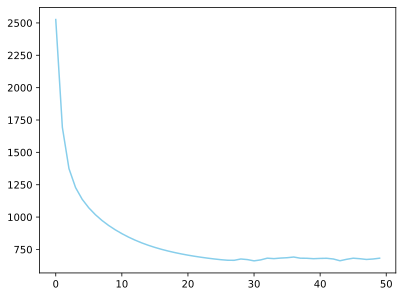

In [75]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# plt.style.use("seaborn")

n_iter = 50
learning_rate = 0.05

history = [backward(model, X, y, learning_rate) for _ in range(n_iter)]

plt.plot(range(len(history)), history, color="skyblue")
plt.show()

In [76]:
learning = one_hot_encode(word_to_id["learning"], len(word_to_id))
result = forward(model, [learning], return_cache=False)[0]

for word in (id_to_word[id] for id in np.argsort(result)[::-1]):
    print(word)

algorithms
so
is
machine
the
intelligence
are
build
learning
difficult
model
tasks
perform
study
do
to
infeasible
automatically
seen
used
subset
mathematical
experience
needed
of
conventional
predictions
wide
or
sample
such
data
improve
variety
explicitly
based
decisions
being
in
develop
through
programmed
order
artificial
on
training
where
make
without
computer
applications
a
that
it
as
known
vision
and
filtering
email


In [77]:
# Embedding

# Building and training was fun and all, 
# but our end goal was not to build a neural network; we wanted to get word embeddings. 
# As stated earlier in this post, 
# the key behind word embeddings is that the rows of the first weight matrix 
# is effectively a dense representation of one-hot encoded vectors each corresponding to various tokens in the text dataset. 
# In our example, therefore, the embedding can simply be obtained by

model["w1"]

array([[-5.57305720e-02,  7.23427168e-01,  1.42766793e+00,
         4.13836346e-01,  1.09789403e-01,  3.96404016e-01,
        -3.23654791e-02, -1.32839573e+00, -2.07298479e+00,
        -2.00559309e-01],
       [-3.86430450e-01, -6.77877396e-01,  1.07298000e+00,
        -2.53811046e+00, -1.18145948e+00, -9.01822904e-01,
        -4.16468330e-01,  1.75842417e+00, -1.08732033e+00,
        -6.55949013e-01],
       [ 1.62823791e+00, -2.21899491e-01,  3.86567835e-01,
        -1.33655211e+00, -1.72245963e+00, -1.07406325e+00,
        -2.90500616e-01,  1.64117091e+00,  1.59114035e-02,
        -4.84919853e-01],
       [ 1.00884844e+00,  7.15729200e-01, -1.02893814e+00,
        -1.77295433e+00, -3.94962744e-01, -1.10942648e+00,
         1.84949774e+00, -6.61012197e-01, -1.95375220e+00,
        -3.68060996e-02],
       [ 8.57490299e-01,  9.15237606e-01,  3.08890348e-01,
        -4.30660072e-01, -1.81460290e+00, -1.41465870e+00,
         4.77219255e-01,  7.00279180e-01, -1.55909535e+00,
        -9.

In [78]:
# In particular,
# what we want is to be able to input a word through a function and receive as output the embedding vector for that given word. 
# Below is a function that implements this feature.

def get_embedding(model, word):
    try:
        idx = word_to_id[word]
    except KeyError:
        print("`word` not in corpus")
    one_hot = one_hot_encode(idx, len(word_to_id))
    return forward(model, one_hot)["a1"]

In [84]:
# When we test out the word "machine" we get a dense ten-dimensional vector as expected.

get_embedding(model, "machine")

array([-0.97910178, -0.66067817,  0.96452486, -0.72495989, -0.24476923,
       -0.32203732, -0.70470781,  0.05842386,  0.59745544,  2.02427206])